In [42]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import ast

x = pd.read_csv('result/embedding-triplets-keys.csv')
x['0'] = x['0'].apply(lambda x: ast.literal_eval(x))

In [43]:
embedding = {}
for i in range(len(x)):
    r = x.iloc[i]
    embedding[r[0]] = r[1]

/var/folders/bw/64y3yr9n6v50fgm86wtx236c0000gn/T/ipykernel_16584/1491516759.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  embedding[r[0]] = r[1]


In [44]:
list(embedding.keys())

['ai:liplearner',
 'ai:deep_neural_network',
 'human:domain-knowledgeable',
 'co:basic',
 'co:creative',
 'ai:feature-based',
 'ai:visualization',
 'ai:example-based',
 'human:middle-aged',
 'co:transparency',
 'ai:lexicon',
 'co:software_engineering',
 'ai:xpath',
 'ai:language-model',
 'co:mid-roll',
 'ai:recommender',
 'ai:steering',
 'ai:participatory',
 'human:practitioner',
 'ai:jitai',
 'co:segmentation',
 'co:ai_trust_score',
 'human:young',
 'co:procedure',
 'human:community',
 'co:user-ai',
 'co:rhetorical',
 'human:emergent',
 'ai:sensemate',
 'ai:decision_support',
 'ai:virtual',
 'human:group',
 'human:crowdworker',
 'human:#variation',
 'co:explanation:planning',
 'co:agreement',
 'ai:integrity',
 'ai:decision',
 'ai:retrolens',
 'co:pde',
 'co:fairness',
 'co:personalization',
 'ai:analogy',
 'co:training_data',
 'co:momentum',
 'ai:dapper',
 'human:live-coder',
 'human:hrm',
 'co:project',
 'co:principles:ethics',
 'ai:segmentation',
 'ai-led',
 'ai:generated',
 'ai:syn

In [46]:
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd

def prepare_embeddings(embedding_dict):
    keywords = list(embedding_dict.keys())
    embeddings = np.array([embedding_dict[k] for k in keywords])
    return keywords, embeddings

def cluster_embeddings(embeddings, eps=0.1):
        clustering = DBSCAN(eps=eps, min_samples=2, metric='cosine').fit(embeddings)
        print(clustering)
        return clustering.labels_

def get_cluster_representatives(clustered_df, embeddings):
    representatives = {}
    
    # Ignore noise points (cluster = -1)
    for cluster_id in clustered_df['cluster'].unique():
        if cluster_id == -1:
            continue
            
        # Get keywords and embeddings for this cluster
        cluster_mask = clustered_df['cluster'] == cluster_id
        cluster_keywords = clustered_df[cluster_mask]['keyword'].tolist()
        cluster_embeddings = embeddings[cluster_mask]
        
        # Calculate centroid
        centroid = np.mean(cluster_embeddings, axis=0)
        
        # Find closest word to centroid using cosine similarity
        similarities = np.dot(cluster_embeddings, centroid)
        similarities = similarities / (np.linalg.norm(cluster_embeddings, axis=1) * np.linalg.norm(centroid))
        representative_idx = np.argmax(similarities)
        
        representatives[int(cluster_id)] = {
            'representative': cluster_keywords[representative_idx],
            'members': cluster_keywords
        }
    
    return representatives

# Modify your original code
def process_keywords(embedding_dict):
    keywords, embeddings = prepare_embeddings(embedding_dict)
    labels = cluster_embeddings(embeddings)
    df = pd.DataFrame({'keyword': keywords, 'cluster': labels})
    
    representatives = get_cluster_representatives(df, embeddings)
    
    return df, representatives

clustered, cluster_representatives = process_keywords(embedding)

for cluster_id, info in cluster_representatives.items():
    print(f"\nCluster {cluster_id}:")
    print(f"Representative: {info['representative']}")
    print(f"All members: {', '.join(info['members'])}")

# print(f"Total keywords: {len(clustered)}")
# print(f"Number of clusters: {len(clustered['cluster'].unique()) - 1}")
# print(f"Unclustered keywords: {len(clustered[clustered['cluster'] == -1])}")

# for i in clustered['cluster'].unique():
#     print(f"Cluster {i}:")
#     print(clustered[clustered['cluster'] == i]['keyword'].tolist())
#     print()

DBSCAN(eps=0.1, metric='cosine', min_samples=2)

Cluster 0:
Representative: human:end-user
All members: human:end-user, human:end_user

Cluster 1:
Representative: co:social
All members: co:social, co:social_media

Cluster 2:
Representative: co:collaborative
All members: co:collaboration, co:collaborative

Cluster 3:
Representative: human:ux_practitioner
All members: human:ux_practitioner, human:ux-practitioner

Cluster 4:
Representative: ai:algorithmic
All members: ai:algorithmic, ai:algorithm

Cluster 5:
Representative: human:older_adults
All members: human:older_adult, human:older_adults

Cluster 6:
Representative: co:robot
All members: co:robotics, co:robot

Cluster 7:
Representative: ai-driven
All members: ai-based, ai-driven, ai-powered, ai-enabled


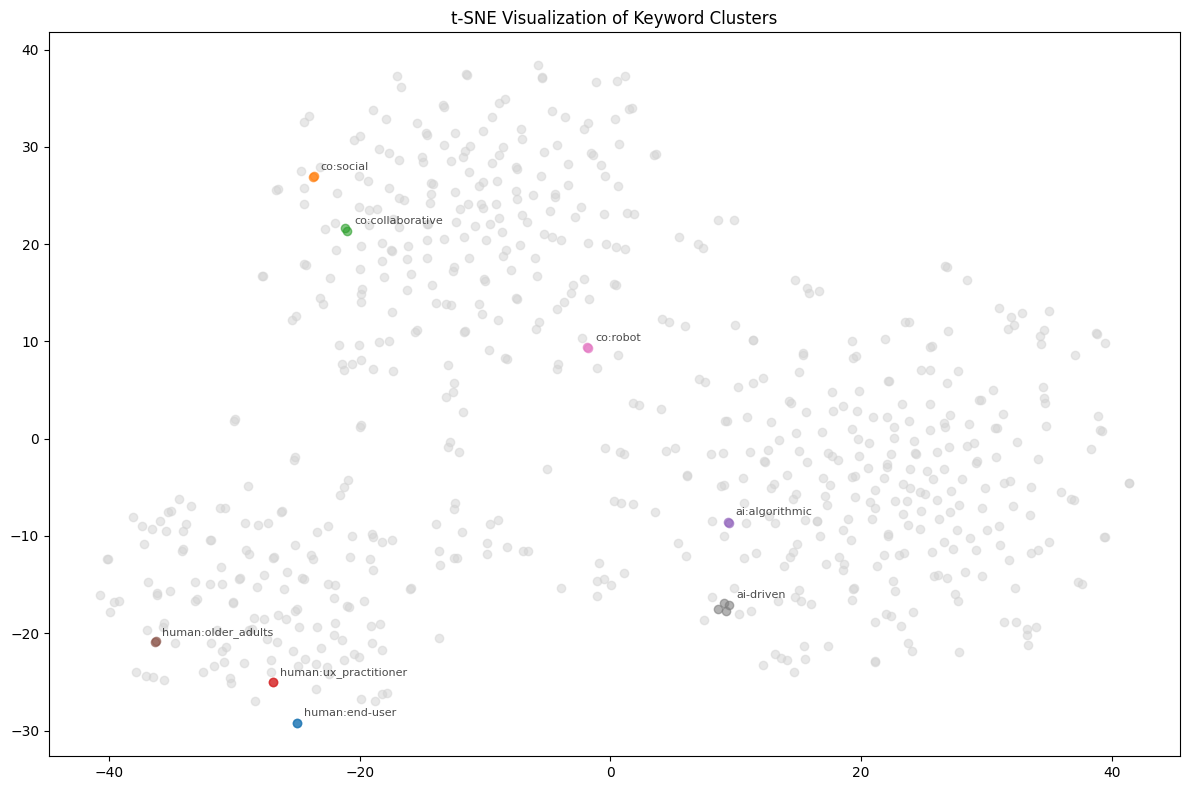

In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

res = set([cluster_representatives[k]['representative'] for k in cluster_representatives])

def visualize_clusters(df, embeddings, perplexity=30, random_state=42):
    # Create t-SNE embedding
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Add t-SNE coordinates to dataframe
    df_viz = df.copy()
    df_viz['x'] = embeddings_2d[:, 0]
    df_viz['y'] = embeddings_2d[:, 1]
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Create color palette for clusters
    n_clusters = len(df_viz['cluster'].unique())
    palette = sns.color_palette("husl", n_clusters)
    
    # Plot noise points first
    noise_mask = df_viz['cluster'] == -1
    plt.scatter(df_viz[noise_mask]['x'], 
                df_viz[noise_mask]['y'], 
                c='lightgray',
                alpha=0.5,
                label='Noise')
    
    # Plot clusters
    for cluster_id in sorted(df_viz['cluster'].unique()):
        if cluster_id == -1:
            continue
            
        mask = df_viz['cluster'] == cluster_id
        plt.scatter(df_viz[mask]['x'], 
                   df_viz[mask]['y'], 
                   label=f'Cluster {cluster_id}',
                   alpha=0.6)
    
    # # Add labels for some points (optional)
    for idx, row in df_viz.iterrows():
        if row['cluster'] != -1 and row['keyword'] in res:  # Only label clustered points
            plt.annotate(row['keyword'], 
                        (row['x'], row['y']),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8,
                        alpha=0.7)
    
    plt.title('t-SNE Visualization of Keyword Clusters')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

keywords, x = prepare_embeddings(embedding)
fig = visualize_clusters(clustered, x)

In [48]:
clustered['representative'] = ''

for i in range(len(clustered)):
    r = clustered.iloc[i]
    c = int(r['cluster'])
    clustered.iloc[i, clustered.columns.get_loc('representative')] = cluster_representatives[c]['representative'] if c != -1 else r['keyword']
    
clustered.to_csv('result/merged-triplets-keys.csv', index=False)